<a href="https://colab.research.google.com/github/evelynlyn2003/Retinopathy-classification/blob/main/%5BHW%5DRetinopathy_classificationV3_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download from google drive or upload file by yourself
!pip install --upgrade gdown==v4.6.3
!gdown --fuzzy '1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7' --output retina-dataset.zip
!unzip -q retina-dataset.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0
Downloading...
From: https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7
To: /content/retina-dataset.zip
100% 622M/622M [00:11<00:00, 53.6MB/s]


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd


In [3]:
# Define Parameters
NUM_CLASS = 5
IMG_SIZE = 224
BS = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Data Visualization

In [4]:
df = pd.read_csv("kaggle_retina/train.csv")
df.head()

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0


In [5]:
paths = glob('kaggle_retina/train/*.png')
paths_test = sorted(glob('kaggle_retina/test/*.png'))
len(paths), len(paths_test)

(2197, 1465)

kaggle_retina/train/7743f4e04a6d.png
label: 2


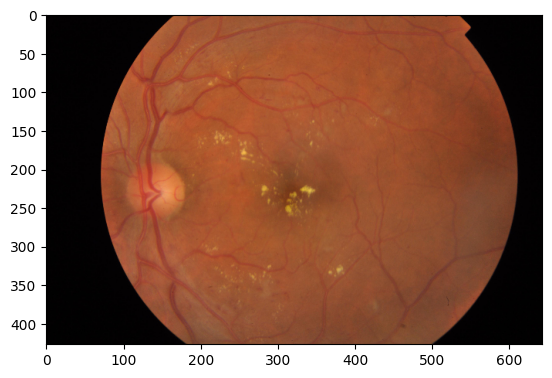

In [6]:
idx = np.random.randint(0, len(df))
row = df.iloc[idx]
filename = row["id_code"]
path = f"kaggle_retina/train/{filename}.png"
img = Image.open(path)
plt.imshow(img)
print(path)
print(f'label: {row["diagnosis"]}')

In [7]:
all_cls = df['diagnosis'].tolist()
print(all_cls[:3])

[1, 4, 0]


<BarContainer object of 5 artists>

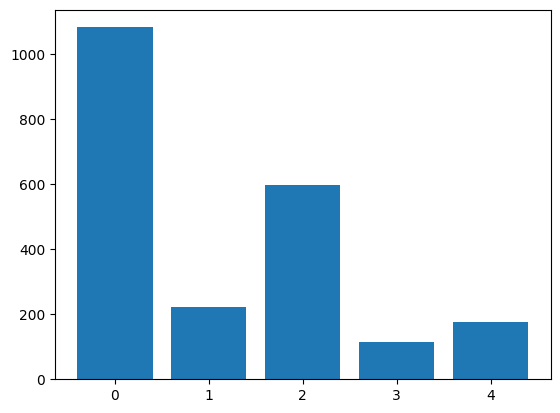

In [8]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Model

Pick your favorite models: https://pytorch.org/vision/stable/models.html

In [9]:
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights

todo


In [45]:
def build_model(num_classes, freeze=True):

    # 1. 載入預訓練的基礎模型
    # 使用最新的預訓練權重 (Weights.IMAGENET1K_V2)
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# 2. 凍結/解凍基礎模型的權重
    if freeze:
        # 凍結所有基礎模型的參數
        for param in model.parameters():
            param.requires_grad = False #關掉梯度需求

    # 3. 構建新的頂部分類層 (將特徵映射到新類別)
    # ResNet 的分類層是名為 'fc' 的全連接層
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(num_ftrs, num_classes))
        # nn.Linear(num_ftrs, num_classes)

    return model

In [13]:
# Mock inputs
inputs = torch.randn(1, 3, 224, 224).to(device)
model = build_model(num_classes=NUM_CLASS, freeze=False).to(device)
outputs = model(inputs)
outputs.shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


--- 基礎模型 ResNet-50 權重未凍結 (微調模式) ---


torch.Size([1, 5])

#### Dataset, DataLoader

In [15]:
class RetinaDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/train/{filename}.png"
        img = Image.open(path)
        img = self.transform(img)

        label = row["diagnosis"]
        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [16]:
df = pd.read_csv("kaggle_retina/train.csv")
train_df, val_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=5566)

Use image transform from pretrained model

In [29]:
import torchvision
transform = torchvision.models.ResNet50_Weights.DEFAULT.transforms()  #ResNet50_Weights

In [31]:
train_ds = RetinaDataset(train_df, transform)
val_ds = RetinaDataset(val_df, transform)

1184 tensor(2)
(224, 224, 3)


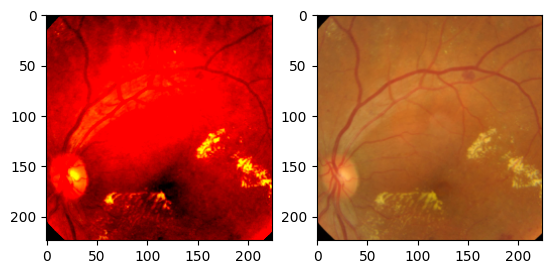

In [32]:
idx = np.random.randint(0, len(train_ds))
img, label = train_ds[idx]
print(idx, label)
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))

# Convert back to original value
img_raw = img.numpy().transpose(1, 2, 0) # (3, 256, 256) -> (256, 256, 3)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_raw = std * img_raw + mean
img_raw = np.clip(img_raw, 0, 1)
print(img_raw.shape)
plt.subplot(1, 2, 2)
plt.imshow(img_raw)
plt.show()

In [33]:
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True,
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS,
                                         pin_memory=True)

#### Training

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [35]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [36]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 0.8673, train_acc: 0.705     val_loss: 1.9048, val_acc: 0.645 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 0.5720, train_acc: 0.772     val_loss: 0.6591, val_acc: 0.775 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 0.4530, train_acc: 0.830     val_loss: 0.8055, val_acc: 0.725 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.3760, train_acc: 0.857     val_loss: 0.5708, val_acc: 0.784 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.2806, train_acc: 0.900     val_loss: 0.7532, val_acc: 0.780 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.1953, train_acc: 0.931     val_loss: 0.7446, val_acc: 0.802 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.1395, train_acc: 0.952     val_loss: 0.6138, val_acc: 0.823 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.1019, train_acc: 0.969     val_loss: 0.7858, val_acc: 0.814 


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.0785, train_acc: 0.977     val_loss: 1.0285, val_acc: 0.793 
Earlystop!


#### Kaggle Submission

https://www.kaggle.com/competitions/diabetic-retinopathy-classification-3/overview

In [37]:
model.load_state_dict(torch.load('best.pth'))
_ = model.eval().to(device)

In [38]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/test/{filename}.png"
        img = Image.open(path)
        img = self.transform(img)
        return img

df = pd.read_csv('kaggle_retina/submission.csv')
test_ds = TestDataset(df, transform)
test_loader = torch.utils.data.DataLoader(test_ds, BS)

In [39]:
# Inference
y_pred = []
with torch.no_grad():
    for x in tqdm(test_loader):
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred.argmax(dim=1))

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

  0%|          | 0/23 [00:00<?, ?it/s]

In [40]:
df['diagnosis'] = y_pred
df.to_csv('submission.csv', index=None)